In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_olist_customers_dataset = pd.read_csv('./documents/olist_customers_dataset.csv')
df_olist_geolocation_dataset = pd.read_csv('./documents/olist_geolocation_dataset.csv')
df_olist_order_items_dataset = pd.read_csv('./documents/olist_order_items_dataset.csv')
df_olist_order_payments_dataset = pd.read_csv('./documents/olist_order_payments_dataset.csv')
df_olist_order_reviews_dataset = pd.read_csv('./documents/olist_order_reviews_dataset.csv')
df_olist_orders_dataset = pd.read_csv('./documents/olist_orders_dataset.csv')
df_olist_products_dataset = pd.read_csv('./documents/olist_products_dataset.csv')
df_olist_sellers_dataset = pd.read_csv('./documents/olist_sellers_dataset.csv')
df_product_category_name_translation = pd.read_csv('./documents/product_category_name_translation.csv')


In [4]:
# Empezamos con la tabla principal de órdenes
df_unificado = df_olist_orders_dataset.copy()

# 1. Unir con información de clientes
df_unificado = df_unificado.merge(
    df_olist_customers_dataset,
    on='customer_id',
    how='left'
)

# 2. Unir con items de órdenes
df_unificado = df_unificado.merge(
    df_olist_order_items_dataset,
    on='order_id',
    how='left'
)

# 3. Unir con información de pagos
df_unificado = df_unificado.merge(
    df_olist_order_payments_dataset,
    on='order_id',
    how='left'
)

# 4. Unir con reviews de órdenes
df_unificado = df_unificado.merge(
    df_olist_order_reviews_dataset,
    on='order_id',
    how='left'
)

# 5. Unir con información de productos
df_unificado = df_unificado.merge(
    df_olist_products_dataset,
    on='product_id',
    how='left'
)

# 6. Unir con traducción de categorías de productos
df_unificado = df_unificado.merge(
    df_product_category_name_translation,
    on='product_category_name',
    how='left'
)

# 7. Unir con información de vendedores
df_unificado = df_unificado.merge(
    df_olist_sellers_dataset,
    on='seller_id',
    how='left'
)

# 8. Para la geolocalización, necesitamos unir tanto para clientes como vendedores
# Primero creamos DataFrames únicos de geolocalización por zip code
geo_customers = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').first().reset_index()
geo_sellers = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').first().reset_index()

# Unir geolocalización de clientes
df_unificado = df_unificado.merge(
    geo_customers,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('', '_customer')
)

# Unir geolocalización de vendedores
df_unificado = df_unificado.merge(
    geo_sellers,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('_customer', '_seller')
)

# Verificar el resultado
print(f"Dimensiones del DataFrame unificado: {df_unificado.shape}")
print(f"Columnas: {df_unificado.columns.tolist()}")
print(f"Primeras filas:")
print(df_unificado.head())

Dimensiones del DataFrame unificado: (119143, 50)
Columnas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_english', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'geolocation_zip_code_prefix_customer', 'geolocation_lat_customer', 'geolocation_lng_custo

In [6]:
df_unificado.shape

(119143, 50)

In [7]:
# Identificar columnas que contienen 'date' en el nombre
columnas_fecha = [col for col in df_unificado.columns if 'date' in col.lower()]
print("Columnas con 'date' encontradas:")
for col in columnas_fecha:
    print(f"- {col}: {df_unificado[col].dtype}")

# Convertir todas las columnas que contienen 'date' a datetime
for columna in columnas_fecha:
    try:
        df_unificado[columna] = pd.to_datetime(df_unificado[columna])
        print(f"✓ Convertida: {columna}")
    except Exception as e:
        print(f"✗ Error en {columna}: {e}")

# Verificar la conversión
print("\nTipos de datos después de la conversión:")
for col in columnas_fecha:
    print(f"- {col}: {df_unificado[col].dtype}")

# También podemos buscar columnas que puedan contener fechas pero no tengan 'date' en el nombre
# Por ejemplo, en el dataset de Olist suelen haber columnas como:
# order_purchase_timestamp, order_approved_at, etc.

# Lista adicional de columnas de timestamp comunes en Olist
columnas_timestamp = [col for col in df_unificado.columns if 'timestamp' in col.lower() or 'time' in col.lower()]
columnas_timestamp = [col for col in columnas_timestamp if col not in columnas_fecha]

print("\nColumnas con 'timestamp' o 'time' encontradas:")
for col in columnas_timestamp:
    print(f"- {col}: {df_unificado[col].dtype}")

# Convertir estas columnas también
for columna in columnas_timestamp:
    try:
        df_unificado[columna] = pd.to_datetime(df_unificado[columna])
        print(f"✓ Convertida: {columna}")
    except Exception as e:
        print(f"✗ Error en {columna}: {e}")

# Verificación final
print("\nResumen de conversiones:")
columnas_fecha_final = [col for col in df_unificado.columns if 'date' in col.lower() or 'timestamp' in col.lower() or 'time' in col.lower()]
for col in columnas_fecha_final:
    print(f"- {col}: {df_unificado[col].dtype}")

# Mostrar algunas fechas para verificar
print("\nPrimeras fechas convertidas:")
for col in columnas_fecha_final[:3]:  # Mostrar solo las primeras 3 para no saturar
    if col in df_unificado.columns:
        print(f"{col}: {df_unificado[col].head(2).tolist()}")

Columnas con 'date' encontradas:
- order_delivered_carrier_date: object
- order_delivered_customer_date: object
- order_estimated_delivery_date: object
- shipping_limit_date: object
- review_creation_date: object
✓ Convertida: order_delivered_carrier_date
✓ Convertida: order_delivered_customer_date
✓ Convertida: order_estimated_delivery_date
✓ Convertida: shipping_limit_date
✓ Convertida: review_creation_date

Tipos de datos después de la conversión:
- order_delivered_carrier_date: datetime64[ns]
- order_delivered_customer_date: datetime64[ns]
- order_estimated_delivery_date: datetime64[ns]
- shipping_limit_date: datetime64[ns]
- review_creation_date: datetime64[ns]

Columnas con 'timestamp' o 'time' encontradas:
- order_purchase_timestamp: object
- review_answer_timestamp: object
✓ Convertida: order_purchase_timestamp
✓ Convertida: review_answer_timestamp

Resumen de conversiones:
- order_purchase_timestamp: datetime64[ns]
- order_delivered_carrier_date: datetime64[ns]
- order_deliver

In [8]:
# Opción con parámetros específicos para manejar formatos problemáticos
for columna in columnas_fecha:
    try:
        df_unificado[columna] = pd.to_datetime(df_unificado[columna], errors='coerce')
        print(f"✓ Convertida: {columna} (valores problemáticos convertidos a NaT)")
    except Exception as e:
        print(f"✗ Error en {columna}: {e}")

# Verificar si hay valores nulos después de la conversión
print("\nValores nulos después de la conversión:")
for col in columnas_fecha:
    if col in df_unificado.columns:
        nulos = df_unificado[col].isnull().sum()
        print(f"- {col}: {nulos} valores nulos")

✓ Convertida: order_delivered_carrier_date (valores problemáticos convertidos a NaT)
✓ Convertida: order_delivered_customer_date (valores problemáticos convertidos a NaT)
✓ Convertida: order_estimated_delivery_date (valores problemáticos convertidos a NaT)
✓ Convertida: shipping_limit_date (valores problemáticos convertidos a NaT)
✓ Convertida: review_creation_date (valores problemáticos convertidos a NaT)

Valores nulos después de la conversión:
- order_delivered_carrier_date: 2086 valores nulos
- order_delivered_customer_date: 3421 valores nulos
- order_estimated_delivery_date: 0 valores nulos
- shipping_limit_date: 833 valores nulos
- review_creation_date: 997 valores nulos


In [9]:
df_unificado.shape

(119143, 50)

In [11]:
# Primero verifiquemos el estado actual de las columnas de fecha
columnas_fecha_verificar = [
    'order_purchase_timestamp',
    'order_approved_at', 
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

print("Estado actual de las columnas de fecha:")
for col in columnas_fecha_verificar:
    if col in df_unificado.columns:
        print(f"- {col}: {df_unificado[col].dtype}")
        print(f"  Ejemplo: {df_unificado[col].iloc[0]}")
        print(f"  Nulos: {df_unificado[col].isnull().sum()}")
    else:
        print(f"- {col}: NO EXISTE en el DataFrame")
    print()

# Corregir las columnas que no son datetime
print("Convirtiendo columnas a datetime...")
for col in columnas_fecha_verificar:
    if col in df_unificado.columns:
        if df_unificado[col].dtype != 'datetime64[ns]':
            print(f"Convirtiendo {col} de {df_unificado[col].dtype} a datetime...")
            df_unificado[col] = pd.to_datetime(df_unificado[col], errors='coerce')
            print(f"✓ {col} convertido a {df_unificado[col].dtype}")
        else:
            print(f"✓ {col} ya es datetime")

# Verificar nuevamente después de la conversión
print("\nEstado después de la conversión:")
for col in columnas_fecha_verificar:
    if col in df_unificado.columns:
        print(f"- {col}: {df_unificado[col].dtype}")
        nulos = df_unificado[col].isnull().sum()
        print(f"  Nulos: {nulos}")

# Ahora crear las diferencias entre fechas
print("\nCreando diferencias entre fechas...")

# 1. Tiempo de aprobación (compra -> aprobación)
if 'order_purchase_timestamp' in df_unificado.columns and 'order_approved_at' in df_unificado.columns:
    mask = df_unificado['order_purchase_timestamp'].notnull() & df_unificado['order_approved_at'].notnull()
    df_unificado.loc[mask, 'tiempo_aprobacion_dias'] = (
        df_unificado.loc[mask, 'order_approved_at'] - df_unificado.loc[mask, 'order_purchase_timestamp']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_aprobacion_dias creado")

# 2. Tiempo preparación (aprobación -> entregado al carrier)
if 'order_approved_at' in df_unificado.columns and 'order_delivered_carrier_date' in df_unificado.columns:
    mask = df_unificado['order_approved_at'].notnull() & df_unificado['order_delivered_carrier_date'].notnull()
    df_unificado.loc[mask, 'tiempo_preparacion_dias'] = (
        df_unificado.loc[mask, 'order_delivered_carrier_date'] - df_unificado.loc[mask, 'order_approved_at']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_preparacion_dias creado")

# 3. Tiempo en tránsito (carrier -> cliente)
if 'order_delivered_carrier_date' in df_unificado.columns and 'order_delivered_customer_date' in df_unificado.columns:
    mask = df_unificado['order_delivered_carrier_date'].notnull() & df_unificado['order_delivered_customer_date'].notnull()
    df_unificado.loc[mask, 'tiempo_transito_dias'] = (
        df_unificado.loc[mask, 'order_delivered_customer_date'] - df_unificado.loc[mask, 'order_delivered_carrier_date']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_transito_dias creado")

# 4. Tiempo total de entrega (compra -> cliente)
if 'order_purchase_timestamp' in df_unificado.columns and 'order_delivered_customer_date' in df_unificado.columns:
    mask = df_unificado['order_purchase_timestamp'].notnull() & df_unificado['order_delivered_customer_date'].notnull()
    df_unificado.loc[mask, 'tiempo_entrega_total_dias'] = (
        df_unificado.loc[mask, 'order_delivered_customer_date'] - df_unificado.loc[mask, 'order_purchase_timestamp']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_entrega_total_dias creado")

# 5. Diferencia vs estimado (real vs estimado)
if 'order_delivered_customer_date' in df_unificado.columns and 'order_estimated_delivery_date' in df_unificado.columns:
    mask = df_unificado['order_delivered_customer_date'].notnull() & df_unificado['order_estimated_delivery_date'].notnull()
    df_unificado.loc[mask, 'diferencia_estimado_real_dias'] = (
        df_unificado.loc[mask, 'order_delivered_customer_date'] - df_unificado.loc[mask, 'order_estimated_delivery_date']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ diferencia_estimado_real_dias creado")

# 6. Tiempo desde aprobación hasta estimado
if 'order_approved_at' in df_unificado.columns and 'order_estimated_delivery_date' in df_unificado.columns:
    mask = df_unificado['order_approved_at'].notnull() & df_unificado['order_estimated_delivery_date'].notnull()
    df_unificado.loc[mask, 'tiempo_aprobado_estimado_dias'] = (
        df_unificado.loc[mask, 'order_estimated_delivery_date'] - df_unificado.loc[mask, 'order_approved_at']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_aprobado_estimado_dias creado")

# 7. Tiempo desde carrier hasta estimado
if 'order_delivered_carrier_date' in df_unificado.columns and 'order_estimated_delivery_date' in df_unificado.columns:
    mask = df_unificado['order_delivered_carrier_date'].notnull() & df_unificado['order_estimated_delivery_date'].notnull()
    df_unificado.loc[mask, 'tiempo_carrier_estimado_dias'] = (
        df_unificado.loc[mask, 'order_estimated_delivery_date'] - df_unificado.loc[mask, 'order_delivered_carrier_date']
    ).dt.total_seconds() / (24 * 3600)
    print("✓ tiempo_carrier_estimado_dias creado")

# Verificar las nuevas columnas creadas
nuevas_columnas = [col for col in df_unificado.columns if 'tiempo' in col or 'diferencia' in col]
print(f"\nNuevas columnas creadas: {len(nuevas_columnas)}")
for col in nuevas_columnas:
    print(f"- {col}")

# Estadísticas descriptivas
print("\nEstadísticas de las nuevas columnas (en días):")
for col in nuevas_columnas:
    if col in df_unificado.columns:
        print(f"\n{col}:")
        print(f"  No nulos: {df_unificado[col].notnull().sum()}")
        if df_unificado[col].notnull().sum() > 0:
            print(f"  Min: {df_unificado[col].min():.2f}")
            print(f"  Max: {df_unificado[col].max():.2f}")
            print(f"  Mean: {df_unificado[col].mean():.2f}")
            print(f"  Median: {df_unificado[col].median():.2f}")

Estado actual de las columnas de fecha:
- order_purchase_timestamp: datetime64[ns]
  Ejemplo: 2017-10-02 10:56:33
  Nulos: 0

- order_approved_at: object
  Ejemplo: 2017-10-02 11:07:15
  Nulos: 177

- order_delivered_carrier_date: datetime64[ns]
  Ejemplo: 2017-10-04 19:55:00
  Nulos: 2086

- order_delivered_customer_date: datetime64[ns]
  Ejemplo: 2017-10-10 21:25:13
  Nulos: 3421

- order_estimated_delivery_date: datetime64[ns]
  Ejemplo: 2017-10-18 00:00:00
  Nulos: 0

Convirtiendo columnas a datetime...
✓ order_purchase_timestamp ya es datetime
Convirtiendo order_approved_at de object a datetime...
✓ order_approved_at convertido a datetime64[ns]
✓ order_delivered_carrier_date ya es datetime
✓ order_delivered_customer_date ya es datetime
✓ order_estimated_delivery_date ya es datetime

Estado después de la conversión:
- order_purchase_timestamp: datetime64[ns]
  Nulos: 0
- order_approved_at: datetime64[ns]
  Nulos: 177
- order_delivered_carrier_date: datetime64[ns]
  Nulos: 2086
- or

In [12]:
df_unificado.shape

(119143, 57)

In [15]:
# Lista de columnas de fecha importantes
columnas_fecha = [
    'order_purchase_timestamp',
    'order_approved_at', 
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

print("Extrayendo componentes de fecha...")

for columna in columnas_fecha:
    if columna in df_unificado.columns:
        # Extraer año
        df_unificado[f'{columna}_ano'] = df_unificado[columna].dt.year
        print(f"✓ {columna}_ano creado")
        
        # Extraer mes (1-12)
        df_unificado[f'{columna}_mes'] = df_unificado[columna].dt.month
        print(f"✓ {columna}_mes creado")
        
        # Extraer día del mes (1-31)
        df_unificado[f'{columna}_dia'] = df_unificado[columna].dt.day
        print(f"✓ {columna}_dia creado")
        
        # Extraer día de la semana (0=lunes, 6=domingo)
        df_unificado[f'{columna}_dia_semana'] = df_unificado[columna].dt.dayofweek
        print(f"✓ {columna}_dia_semana creado")
        
        # Extraer semana del año
        df_unificado[f'{columna}_semana_ano'] = df_unificado[columna].dt.isocalendar().week
        print(f"✓ {columna}_semana_ano creado")
        
        # Extraer trimestre
        df_unificado[f'{columna}_trimestre'] = df_unificado[columna].dt.quarter
        print(f"✓ {columna}_trimestre creado")
        
        # Indicador de fin de semana
        df_unificado[f'{columna}_fin_semana'] = df_unificado[columna].dt.dayofweek.isin([5, 6]).astype(int)
        print(f"✓ {columna}_fin_semana creado")
        
        print()  # Línea en blanco para separar

# Verificar las nuevas columnas creadas
nuevas_columnas_fecha = [col for col in df_unificado.columns if any(x in col for x in ['_ano', '_mes', '_dia', '_semana', '_trimestre', '_fin_semana', '_dia_semana'])]
print(f"Total de nuevas columnas de fecha creadas: {len(nuevas_columnas_fecha)}")

# Mostrar algunas estadísticas de las nuevas columnas
print("\nEstadísticas de las nuevas columnas:")
for columna_base in columnas_fecha:
    if columna_base in df_unificado.columns:
        print(f"\n{columna_base}:")
        componentes = [col for col in nuevas_columnas_fecha if columna_base in col]
        for comp in componentes[:3]:  # Mostrar solo los primeros 3 componentes para no saturar
            if comp in df_unificado.columns:
                print(f"  {comp}: {df_unificado[comp].nunique()} valores únicos")

# También podemos crear algunas métricas adicionales interesantes
print("\nCreando métricas temporales adicionales...")

# Día del año (1-365/366)
for columna in ['order_purchase_timestamp', 'order_delivered_customer_date']:
    if columna in df_unificado.columns:
        df_unificado[f'{columna}_dia_ano'] = df_unificado[columna].dt.dayofyear
        print(f"✓ {columna}_dia_ano creado")

# Mes-Año combinado (para análisis de tendencias)
for columna in ['order_purchase_timestamp', 'order_delivered_customer_date']:
    if columna in df_unificado.columns:
        df_unificado[f'{columna}_mes_ano'] = df_unificado[columna].dt.to_period('M')
        print(f"✓ {columna}_mes_ano creado")

# Hora del día (si las fechas incluyen hora)
for columna in columnas_fecha:
    if columna in df_unificado.columns:
        # Extraer hora
        df_unificado[f'{columna}_hora'] = df_unificado[columna].dt.hour
        print(f"✓ {columna}_hora creado")
        
        # Categorizar en partes del día
        condiciones = [
            (df_unificado[columna].dt.hour >= 6) & (df_unificado[columna].dt.hour < 12),
            (df_unificado[columna].dt.hour >= 12) & (df_unificado[columna].dt.hour < 18),
            (df_unificado[columna].dt.hour >= 18) & (df_unificado[columna].dt.hour < 24),
            (df_unificado[columna].dt.hour >= 0) & (df_unificado[columna].dt.hour < 6)
        ]
        categorias = ['mañana', 'tarde', 'noche', 'madrugada']
        df_unificado[f'{columna}_parte_dia'] = np.select(condiciones, categorias, default='desconocido')
        print(f"✓ {columna}_parte_dia creado")

# Mostrar resumen final
columnas_temporales_totales = [col for col in df_unificado.columns if any(x in col for x in [
    '_ano', '_mes', '_dia', '_semana', '_trimestre', '_fin_semana', 
    '_dia_semana', '_hora', '_parte_dia', '_dia_ano', '_mes_ano'
])]

print(f"\nResumen final:")
print(f"Total de columnas temporales creadas: {len(columnas_temporales_totales)}")
print(f"Total de columnas en el DataFrame: {len(df_unificado.columns)}")

# Mostrar primeras filas con algunas columnas nuevas
print("\nPrimeras filas con algunas columnas nuevas:")
columnas_ejemplo = [col for col in columnas_temporales_totales if 'order_purchase_timestamp' in col][:5]
if columnas_ejemplo:
    print(df_unificado[columnas_ejemplo].head())

Extrayendo componentes de fecha...
✓ order_purchase_timestamp_ano creado
✓ order_purchase_timestamp_mes creado
✓ order_purchase_timestamp_dia creado
✓ order_purchase_timestamp_dia_semana creado
✓ order_purchase_timestamp_semana_ano creado
✓ order_purchase_timestamp_trimestre creado
✓ order_purchase_timestamp_fin_semana creado

✓ order_approved_at_ano creado
✓ order_approved_at_mes creado
✓ order_approved_at_dia creado
✓ order_approved_at_dia_semana creado
✓ order_approved_at_semana_ano creado
✓ order_approved_at_trimestre creado
✓ order_approved_at_fin_semana creado

✓ order_delivered_carrier_date_ano creado
✓ order_delivered_carrier_date_mes creado
✓ order_delivered_carrier_date_dia creado
✓ order_delivered_carrier_date_dia_semana creado
✓ order_delivered_carrier_date_semana_ano creado
✓ order_delivered_carrier_date_trimestre creado
✓ order_delivered_carrier_date_fin_semana creado

✓ order_delivered_customer_date_ano creado
✓ order_delivered_customer_date_mes creado
✓ order_delivered_

In [16]:
df_unificado.shape

(119143, 106)

In [17]:
# Primero, vamos a preparar los datos de geolocalización
print("Preparando datos de geolocalización...")

# Crear DataFrames únicos de geolocalización por zip code para clientes y vendedores
# Usaremos las coordenadas promedio para cada zip code para mayor precisión

# Geolocalización para clientes
geo_customers = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()
geo_customers.columns = ['customer_zip_code_prefix', 'customer_avg_lat', 'customer_avg_lng']
print(f"Geolocalización de clientes: {geo_customers.shape}")

# Geolocalización para vendedores
geo_sellers = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()
geo_sellers.columns = ['seller_zip_code_prefix', 'seller_avg_lat', 'seller_avg_lng']
print(f"Geolocalización de vendedores: {geo_sellers.shape}")

# Unir las coordenadas al DataFrame principal
print("Uniendo coordenadas al DataFrame unificado...")

# Unir coordenadas de clientes
df_unificado = df_unificado.merge(
    geo_customers,
    on='customer_zip_code_prefix',
    how='left'
)
print("✓ Coordenadas de clientes unidas")

# Unir coordenadas de vendedores
df_unificado = df_unificado.merge(
    geo_sellers,
    on='seller_zip_code_prefix',
    how='left'
)
print("✓ Coordenadas de vendedores unidas")

# Verificar nulos después del merge
print("\nVerificando nulos en coordenadas:")
print(f"Coordenadas de clientes nulas: {df_unificado['customer_avg_lat'].isnull().sum()}")
print(f"Coordenadas de vendedores nulas: {df_unificado['seller_avg_lat'].isnull().sum()}")

# Función para calcular distancia usando la fórmula de Haversine
def calcular_distancia_haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia en kilómetros entre dos puntos usando la fórmula de Haversine
    """
    # Radio de la Tierra en kilómetros
    R = 6371.0
    
    # Convertir grados a radianes
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Diferencia entre las coordenadas
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    distancia = R * c
    return distancia

# Calcular distancias
print("\nCalculando distancias entre compradores y vendedores...")

# Crear máscara para filas con coordenadas válidas
mask_coordenadas = (
    df_unificado['customer_avg_lat'].notnull() & 
    df_unificado['customer_avg_lng'].notnull() &
    df_unificado['seller_avg_lat'].notnull() & 
    df_unificado['seller_avg_lng'].notnull()
)

print(f"Filas con coordenadas válidas: {mask_coordenadas.sum()}")

# Calcular distancia usando Haversine
df_unificado.loc[mask_coordenadas, 'distancia_km'] = calcular_distancia_haversine(
    df_unificado.loc[mask_coordenadas, 'customer_avg_lat'],
    df_unificado.loc[mask_coordenadas, 'customer_avg_lng'],
    df_unificado.loc[mask_coordenadas, 'seller_avg_lat'],
    df_unificado.loc[mask_coordenadas, 'seller_avg_lng']
)

print("✓ Distancia en km calculada")

# También podemos crear categorías de distancia para análisis
print("\nCreando categorías de distancia...")

# Definir categorías de distancia
bins = [0, 50, 100, 200, 500, 1000, 5000]
labels = ['Muy cercana (<50km)', 'Cercana (50-100km)', 'Media (100-200km)', 
          'Lejana (200-500km)', 'Muy lejana (500-1000km)', 'Extrema (>1000km)']

df_unificado['distancia_categoria'] = pd.cut(
    df_unificado['distancia_km'], 
    bins=bins, 
    labels=labels, 
    right=False
)

print("✓ Categorías de distancia creadas")

# Calcular distancia aproximada usando diferencia simple de coordenadas (más rápida)
# Esto puede ser útil como alternativa o validación
print("\nCalculando distancia aproximada...")

df_unificado.loc[mask_coordenadas, 'distancia_aproximada_km'] = np.sqrt(
    (df_unificado.loc[mask_coordenadas, 'customer_avg_lat'] - df_unificado.loc[mask_coordenadas, 'seller_avg_lat'])**2 +
    (df_unificado.loc[mask_coordenadas, 'customer_avg_lng'] - df_unificado.loc[mask_coordenadas, 'seller_avg_lng'])**2
) * 111  # Aproximación: 1 grado ≈ 111 km

print("✓ Distancia aproximada calculada")

# Estadísticas de las distancias
print("\nEstadísticas de distancias calculadas:")
if 'distancia_km' in df_unificado.columns:
    print(f"Distancias calculadas: {df_unificado['distancia_km'].notnull().sum()}")
    print(f"Distancia mínima: {df_unificado['distancia_km'].min():.2f} km")
    print(f"Distancia máxima: {df_unificado['distancia_km'].max():.2f} km")
    print(f"Distancia promedio: {df_unificado['distancia_km'].mean():.2f} km")
    print(f"Distancia mediana: {df_unificado['distancia_km'].median():.2f} km")
    
    print("\nDistribución por categorías:")
    print(df_unificado['distancia_categoria'].value_counts().sort_index())

# Verificar correlación entre distancia y tiempo de entrega
if 'tiempo_entrega_total_dias' in df_unificado.columns and 'distancia_km' in df_unificado.columns:
    mask_valores = df_unificado['distancia_km'].notnull() & df_unificado['tiempo_entrega_total_dias'].notnull()
    correlacion = df_unificado.loc[mask_valores, 'distancia_km'].corr(df_unificado.loc[mask_valores, 'tiempo_entrega_total_dias'])
    print(f"\nCorrelación entre distancia y tiempo de entrega: {correlacion:.4f}")

# Mostrar primeras filas con las nuevas columnas de distancia
columnas_distancia = ['distancia_km', 'distancia_aproximada_km', 'distancia_categoria']
if all(col in df_unificado.columns for col in columnas_distancia):
    print("\nPrimeras filas con distancias calculadas:")
    print(df_unificado[columnas_distancia + ['customer_zip_code_prefix', 'seller_zip_code_prefix']].head(10))

# Limpiar columnas temporales si es necesario (opcional)
# columnas_limpiar = ['customer_avg_lat', 'customer_avg_lng', 'seller_avg_lat', 'seller_avg_lng']
# df_unificado = df_unificado.drop(columns=columnas_limpiar)
# print("✓ Columnas temporales de coordenadas limpiadas")

Preparando datos de geolocalización...
Geolocalización de clientes: (19015, 3)
Geolocalización de vendedores: (19015, 3)
Uniendo coordenadas al DataFrame unificado...
✓ Coordenadas de clientes unidas
✓ Coordenadas de vendedores unidas

Verificando nulos en coordenadas:
Coordenadas de clientes nulas: 322
Coordenadas de vendedores nulas: 1098

Calculando distancias entre compradores y vendedores...
Filas con coordenadas válidas: 117729
✓ Distancia en km calculada

Creando categorías de distancia...
✓ Categorías de distancia creadas

Calculando distancia aproximada...
✓ Distancia aproximada calculada

Estadísticas de distancias calculadas:
Distancias calculadas: 117729
Distancia mínima: 0.00 km
Distancia máxima: 8677.91 km
Distancia promedio: 597.22 km
Distancia mediana: 431.95 km

Distribución por categorías:
distancia_categoria
Muy cercana (<50km)        14424
Cercana (50-100km)          7514
Media (100-200km)           8177
Lejana (200-500km)         37357
Muy lejana (500-1000km)    31

In [18]:
df_unificado.shape

(119143, 113)

In [20]:
df_unificado.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_delivered_customer_date_parte_dia,order_estimated_delivery_date_hora,order_estimated_delivery_date_parte_dia,customer_avg_lat,customer_avg_lng,seller_avg_lat,seller_avg_lng,distancia_km,distancia_categoria,distancia_aproximada_km
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,noche,0,madrugada,-23.576983,-46.587161,-23.680729,-46.444238,18.576110,Muy cercana (<50km),19.603456
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,noche,0,madrugada,-23.576983,-46.587161,-23.680729,-46.444238,18.576110,Muy cercana (<50km),19.603456
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,noche,0,madrugada,-23.576983,-46.587161,-23.680729,-46.444238,18.576110,Muy cercana (<50km),19.603456
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,tarde,0,madrugada,-12.177924,-44.660711,-19.807681,-43.980427,851.495069,Muy lejana (500-1000km),850.262665
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,noche,0,madrugada,-16.745150,-48.514783,-21.363502,-48.229601,514.410666,Muy lejana (500-1000km),513.613515


In [21]:
# Opción 1: Guardar con la configuración básica
df_unificado.to_csv('./documents/olist_dataset_unificado.csv', index=False)
print("✓ DataFrame guardado como 'olist_dataset_unificado.csv'")

✓ DataFrame guardado como 'olist_dataset_unificado.csv'


In [22]:
if 'product_weight_g' in df_unificado.columns and 'product_length_cm' in df_unificado.columns:
    df_unificado['volumetric_weight'] = (
        df_unificado['product_length_cm'] * 
        df_unificado['product_height_cm'] * 
        df_unificado['product_width_cm']
    ) / 6000  # Factor de conversión común
    print("✓ volumetric_weight creado")

✓ volumetric_weight creado


In [23]:
# Densidad del producto
if 'product_weight_g' in df_unificado.columns and 'volumetric_weight' in df_unificado.columns:
    df_unificado['product_density'] = df_unificado['product_weight_g'] / (df_unificado['volumetric_weight'] + 0.001)
    print("✓ product_density creado")

✓ product_density creado


ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO
Correlaciones más altas (positivas y negativas):
tiempo_entrega_total_dias               1.000000
tiempo_transito_dias                    0.922312
diferencia_estimado_real_dias           0.597786
distancia_aproximada_km                 0.393799
tiempo_preparacion_dias                 0.393797
distancia_km                            0.391249
tiempo_aprobado_estimado_dias           0.373653
geolocation_zip_code_prefix_customer    0.271974
customer_zip_code_prefix                0.271704
customer_avg_lat                        0.255957
Name: tiempo_entrega_total_dias, dtype: float64

...
order_delivered_customer_date_mes          -0.089059
order_delivered_customer_date_semana_ano   -0.091468
order_delivered_customer_date_dia_ano      -0.091759
order_delivered_customer_date_trimestre    -0.094105
order_estimated_delivery_date_mes          -0.098662
order_estimated_delivery_date_semana_ano   -0.099784
order_estimated_delivery_date_trimestre  

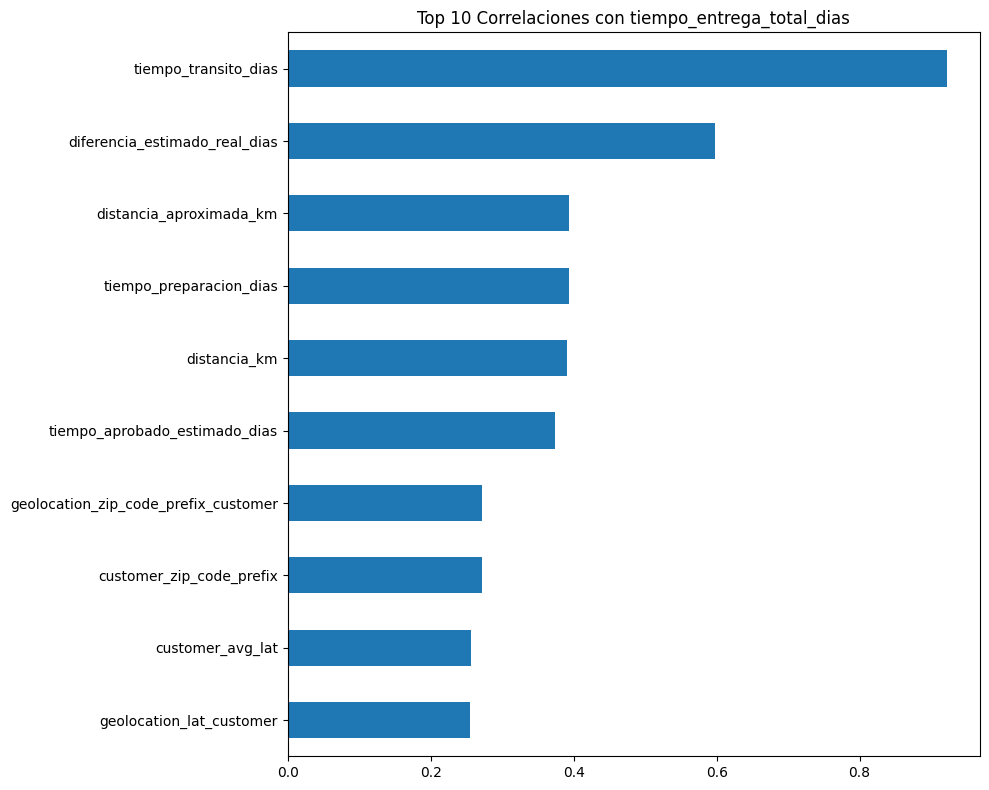

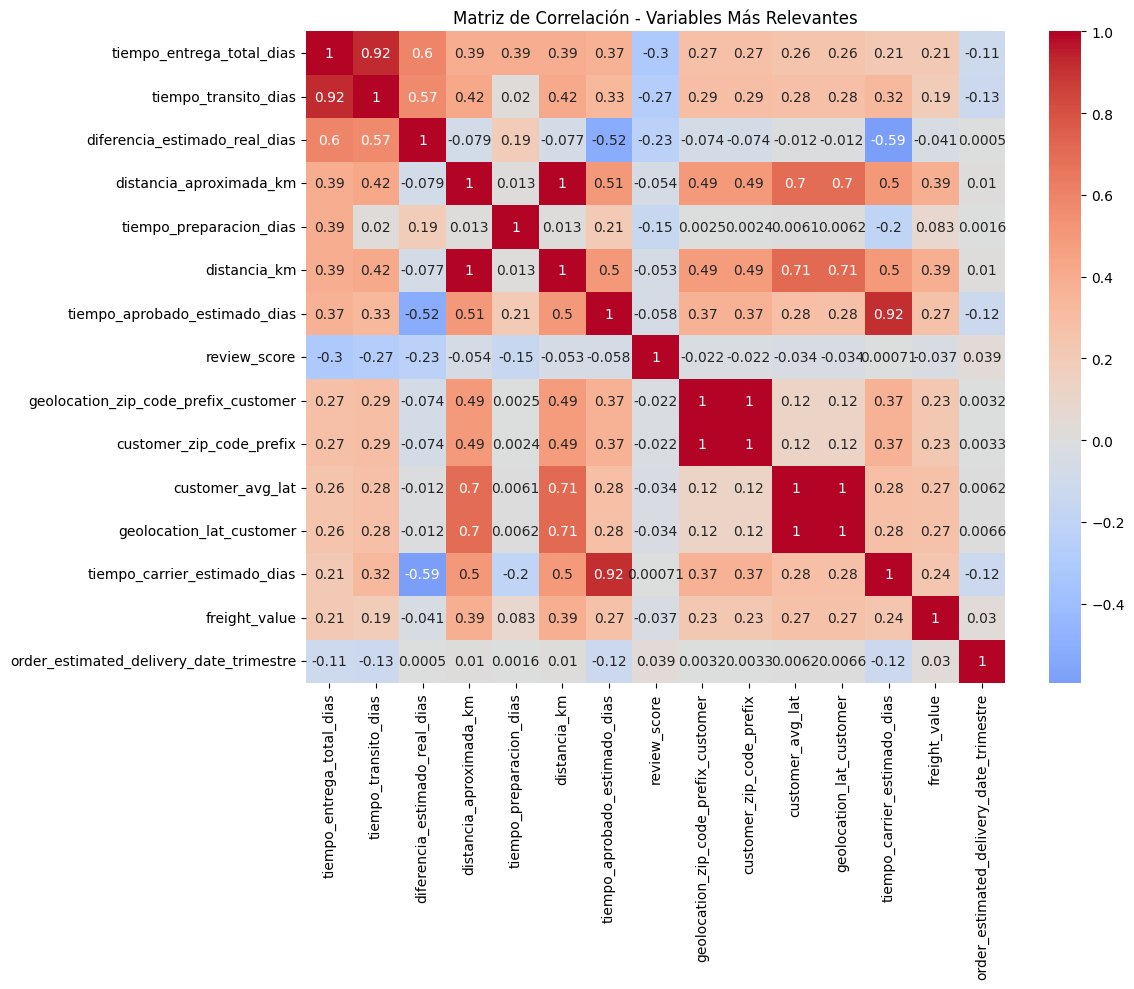

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Primero identifiquemos nuestra variable objetivo
variable_objetivo = 'tiempo_entrega_total_dias'  # Ajusta según tu caso

print("ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO")
print("="*50)

# Calcular correlaciones con la variable objetivo
if variable_objetivo in df_unificado.columns:
    correlaciones = df_unificado.corr(numeric_only=True)[variable_objetivo].sort_values(ascending=False)
    
    print("Correlaciones más altas (positivas y negativas):")
    print(correlaciones.head(10))
    print("\n...")
    print(correlaciones.tail(10))
    
    # Visualizar top 20 correlaciones
    plt.figure(figsize=(10, 8))
    top_correlaciones = correlaciones.drop(variable_objetivo).head(10).sort_values()
    top_correlaciones.plot(kind='barh')
    plt.title(f'Top 10 Correlaciones con {variable_objetivo}')
    plt.tight_layout()
    plt.show()

# Matriz de correlación de las variables más correlacionadas
top_variables = correlaciones.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(df_unificado[top_variables].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Variables Más Relevantes')
plt.tight_layout()
plt.show()


ANÁLISIS DE IMPORTANCIA CON RANDOM FOREST
Filas para análisis: 112660
Variables para análisis: 78

Top 20 Variables por Importancia:
                                     feature  importance
24                      tiempo_transito_dias    0.820163
23                   tiempo_preparacion_dias    0.137158
25             diferencia_estimado_real_dias    0.034554
22                    tiempo_aprobacion_dias    0.006114
27              tiempo_carrier_estimado_dias    0.000293
77                           product_density    0.000140
26             tiempo_aprobado_estimado_dias    0.000128
52  order_delivered_customer_date_dia_semana    0.000062
31       order_purchase_timestamp_dia_semana    0.000059
65             order_purchase_timestamp_hora    0.000054
3                              freight_value    0.000047
68        order_delivered_customer_date_hora    0.000047
75                   distancia_aproximada_km    0.000039
76                         volumetric_weight    0.000038
2          

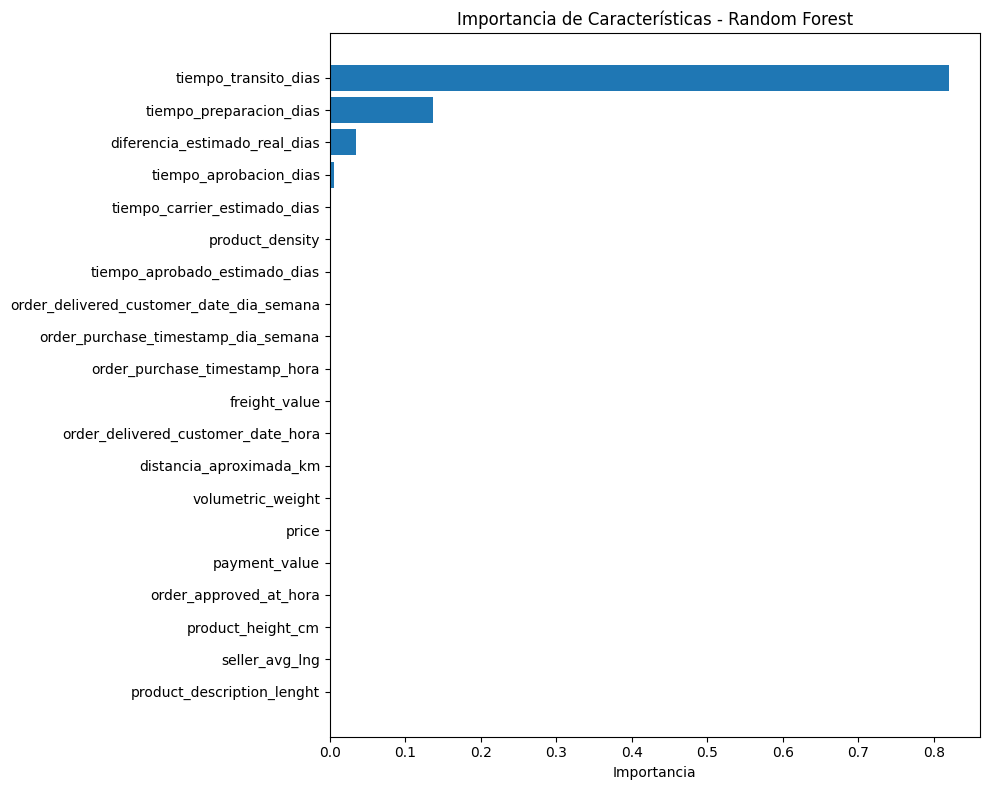

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

print("\nANÁLISIS DE IMPORTANCIA CON RANDOM FOREST")
print("="*50)

# Preparar datos para el modelo
def preparar_datos_para_importancia(df, target_col):
    # Seleccionar solo variables numéricas y la objetivo
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Eliminar columnas con muchos nulos (>50%)
    umbral_nulos = 0.5
    columnas_validas = numeric_df.columns[numeric_df.isnull().mean() < umbral_nulos]
    numeric_df = numeric_df[columnas_validas]
    
    # Eliminar la variable objetivo del conjunto de features
    X = numeric_df.drop(columns=[target_col], errors='ignore')
    y = numeric_df[target_col]
    
    # Eliminar filas con nulos
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X[mask]
    y = y[mask]
    
    return X, y

if variable_objetivo in df_unificado.columns:
    X, y = preparar_datos_para_importancia(df_unificado, variable_objetivo)
    
    print(f"Filas para análisis: {X.shape[0]}")
    print(f"Variables para análisis: {X.shape[1]}")
    
    # Entrenar Random Forest para importancia
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Obtener importancia de características
    importancia = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Variables por Importancia:")
    print(importancia.head(20))
    
    # Visualizar importancia
    plt.figure(figsize=(10, 8))
    top_20 = importancia.head(20).sort_values('importance', ascending=True)
    plt.barh(top_20['feature'], top_20['importance'])
    plt.title('Importancia de Características - Random Forest')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()